## In this notebook we will modeling play by play yac data


In [135]:
##Import required packages
#Data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

#For model creation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf

#Dimensionality reduction
from sklearn.decomposition import PCA

#For scaling data
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

#Plotting animation
import plotly.graph_objects as go
import plotly.express as px

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
#Lets first get all of our data into pandas dataframes
games = pd.read_csv('data/games.csv')
players = pd.read_csv('data/players.csv')
plays = pd.read_csv('data/plays.csv')
tackles = pd.read_csv('data/tackles.csv')
# Assuming your tracking data files are named tracking_week_1.csv, tracking_week_2.csv, ..., tracking_week_9.csv
data_dir = Path("data/")  # Update with the correct path
tracking_dfs = sorted(data_dir.glob("tracking_week_*.csv"))

# Create an empty list to store individual week dataframes
week_dfs = []

# Iterate through each tracking data file and load it into a dataframe
for week_number, tracking_file in enumerate(tracking_dfs, start=1):
    week_df = pd.read_csv(tracking_file)
    
    # Add a 'week' column with the corresponding week number
    week_df['week'] = week_number
    
    # Append the dataframe to the list
    week_dfs.append(week_df)

# Combine all week dataframes into a single dataframe
tracking = pd.concat(week_dfs, ignore_index=True)


In [4]:
#Filter out any non-pass plays
yac_df = plays[['gameId','playId','ballCarrierId','ballCarrierDisplayName','yardsToGo','possessionTeam','defensiveTeam','yardlineSide','yardlineNumber']]
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41
1,2022091103,3126,52457,Chase Claypool,10,PIT,CIN,PIT,34
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30
3,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37
4,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35
...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39
12482,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30
12483,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41
12484,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34


In [5]:
# Get plays with 'first_contact' event
plays_with_first_contact = tracking[tracking['event'] == 'first_contact'][['gameId', 'playId']].drop_duplicates()

# Get plays with the specified events
relevant_events = ['pass_outcome_caught', 'run', 'handoff']
plays_with_other_events = tracking[tracking['event'].isin(relevant_events)][['gameId', 'playId']].drop_duplicates()

# Filter yac_df for plays that satisfy both conditions
filtered_plays = plays_with_first_contact.merge(plays_with_other_events, on=['gameId', 'playId'], how='inner')
yac_df = yac_df[yac_df.set_index(['gameId', 'playId']).index.isin(filtered_plays.set_index(['gameId', 'playId']).index)]


## Calculate yards gained after the 'first_contact' frame

In [6]:
def yards_after_contact(row, tracking):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking[(tracking.gameId == gameId) & (tracking.playId == playId) & (tracking.nflId == ballCarrierId)]

    # Check if there are matching rows
    if not selected_tracking.empty:
        first_contact_row = selected_tracking.loc[selected_tracking.event == 'first_contact', 'x']
        tackle_row = selected_tracking.loc[selected_tracking.event == 'tackle', 'x']

        # Check if rows with 'first_contact' and 'tackle' events exist
        if not first_contact_row.empty and not tackle_row.empty:
            x_first_contact = first_contact_row.values[0]
            x_tackle = tackle_row.values[0]

            play_direction = selected_tracking['playDirection'].values[0]

            if play_direction == 'right':
                yards_gained = x_tackle - x_first_contact
            else:
                yards_gained = x_first_contact - x_tackle

            # Forward progress rule
            yards_gained = max(0, yards_gained)
        else:
            # If events are not found, set yards_gained to 0
            yards_gained = 0
    else:
        # If no matching rows are found, set yards_gained to 0
        yards_gained = 0

    return yards_gained


In [7]:
yac_df['yards_after_contact'] = yac_df.apply(yards_after_contact, args=(tracking,), axis=1)
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30
2,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52
3,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37,4.74
4,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35,2.97
5,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12
...,...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39,2.26
12482,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30,1.25
12483,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41,3.77
12484,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34,0.00


## Which defender made first contact?
I will determine this by calculating the euclidean distance between all defenders and the ballcarrier at the frame of first contact. I will then drop any plays in which the labelled "first defender" is not accredited with a tackle in the tackles dataframe

In [8]:
tracking_fc = pd.merge(tracking, plays[['gameId','playId', 'ballCarrierId', 'defensiveTeam']], on = ['gameId','playId'], how='left')


# Drop rows with NaN values in the 'nflId' column
tracking_fc.dropna(subset=['nflId'], inplace=True)

tracking_fc['nflId'] = pd.to_numeric(tracking_fc['nflId'], errors='coerce').astype(int)

tracking_fc = tracking_fc[(tracking_fc.nflId == tracking_fc.ballCarrierId) | (tracking_fc.club == tracking_fc.defensiveTeam)]
tracking_fc = tracking_fc[
    tracking_fc.set_index(['gameId', 'playId']).index.isin(yac_df.set_index(['gameId', 'playId']).index)
]

tracking_fc = pd.merge(tracking_fc, yac_df[['gameId','playId','ballCarrierDisplayName','yardsToGo','yards_after_contact']], on = ['gameId','playId'], how='left')

In [9]:
# Merge DataFrames based on gameId, playId, and nflId
tracking_fc = pd.merge(tracking_fc, tackles[['gameId', 'playId', 'nflId']], 
                     on=['gameId', 'playId', 'nflId'], how='left', indicator=True)

# Add a new column 'involved_in_tackle' with 1 if there is a match and 0 otherwise
tracking_fc['involved_in_tackle'] = (tracking_fc['_merge'] == 'both').astype(int)

# Drop the indicator column and any other columns introduced by the merge
tracking_fc.drop(['_merge'], axis=1, inplace=True)


In [10]:
# Filter the DataFrame to include only frames with 'first_contact' event
caught_frames = tracking_fc[tracking_fc['event'] == 'first_contact']

# Add a new column 'defender_first_contact' to tracking_fc
tracking_fc['defender_first_contact'] = np.nan

# Iterate through unique pairs of gameId and playId
for (game_id, play_id) in caught_frames[['gameId', 'playId']].drop_duplicates().itertuples(index=False):
    # Get the data for the current gameId and playId
    play_data = caught_frames[(caught_frames['gameId'] == game_id) & (caught_frames['playId'] == play_id)]
    
    # Get the coordinates of the ballcarrier
    ballcarrier_coords = play_data[play_data['nflId'] == play_data['ballCarrierId']][['x', 'y']].values[0]
    
    # Calculate Euclidean distance for each defender
    play_data['distance_to_ballcarrier'] = play_data.apply(
        lambda row: np.linalg.norm([row['x'] - ballcarrier_coords[0], row['y'] - ballcarrier_coords[1]]),
        axis=1
    )
    
    # Exclude the ballcarrier from the candidates for first contact
    play_data = play_data[play_data['nflId'] != play_data['ballCarrierId']]
    
    # Find the defender with the minimum distance (first contact)
    defender_first_contact = play_data.loc[play_data['distance_to_ballcarrier'].idxmin()]['nflId']
    
    # Fill the 'defender_first_contact' value for all rows with the same 'gameId' and 'playId'
    tracking_fc.loc[(tracking_fc['gameId'] == game_id) & (tracking_fc['playId'] == play_id), 'defender_first_contact'] = defender_first_contact

# Now, tracking_fc DataFrame has a new column 'defender_first_contact' with the defender's nflId for each first contact event.


In [11]:
tracking_fc['defender_first_contact'] = tracking_fc['defender_first_contact'].astype(int)

In [12]:

yac_df = pd.merge(yac_df, tracking_fc[['gameId', 'playId', 'defender_first_contact']].drop_duplicates(),
                  on=['gameId', 'playId'], how='left')

yac_df.rename(columns={'defender_first_contact': 'nflId'}, inplace=True)

print(yac_df.shape[0])

#only include plays where the first defender is also listed in the tackles dataframe
yac_df = yac_df[
    yac_df.set_index(['gameId', 'playId', 'nflId']).index.isin(tackles.set_index(['gameId', 'playId', 'nflId']).index)
]

yac_df.rename(columns={'nflId': 'defender_first_contact'}, inplace=True)

print(yac_df.shape[0])

10522
8705


## Feature Engineering
Lets come up with some variables that are likely to impact the success of a tackle. We will calculate:
1. Avg speed of both players between the pass catch and the collision
2. Distance the players are from one another at the time the pass was caught
3. Difference in angle between the defender and offense (from the offense pov)
4. Height and Weight of both the ballcarrier and the defender

In [13]:
def get_avg_speed(row, tracking_df, defender):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Filter for the relevant events
    relevant_events = ['handoff', 'run', 'pass_outcome_caught']
    event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    last_frame = selected_tracking[selected_tracking.event == 'first_contact']['frameId'].values[0]
    numframes = last_frame - event_frame + 1

    speed_defender = 0
    speed_ballcarrier = 0
    
    for frame in range(event_frame, last_frame + 1):  # Use range to iterate over frames
        speed_defender += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == defenderId)]['s'].values[0] / numframes
        speed_ballcarrier += selected_tracking[(selected_tracking.frameId == frame) & (selected_tracking.nflId == selected_tracking.ballCarrierId)]['s'].values[0] / numframes


    if defender:
        return speed_defender
    else:
        return speed_ballcarrier


In [14]:
#Get the average speed of both the ballcarrier and the defender
yac_df.loc[:, 'avg_speed_defender'] = yac_df.apply(get_avg_speed, args=(tracking_fc, True), axis=1)
yac_df.loc[:, 'avg_speed_ballcarrier'] = yac_df.apply(get_avg_speed, args=(tracking_fc, False), axis=1)


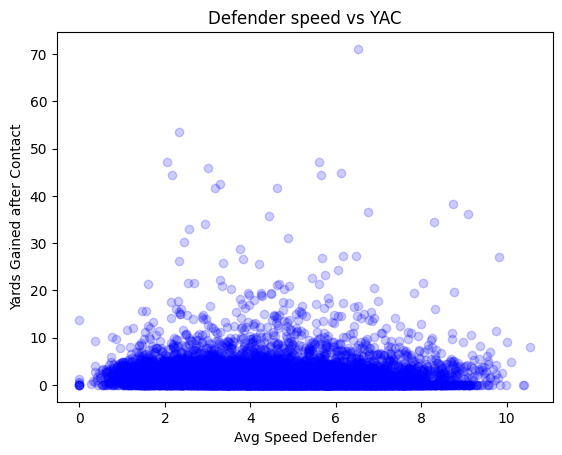

In [124]:
# Create a scatter plot
plt.scatter(yac_df['avg_speed_defender'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Avg Speed Defender')
plt.ylabel('Yards Gained after Contact')
plt.title('Defender speed vs YAC')

# Show the plot
plt.show()

While the scatter plot doesn't suggest a straightforward relationship between the speed of the defender and yards gained after contact, the inclusion of this feature acknowledges the potential for non-linear or subtle connections that may become evident through more sophisticated analysis.

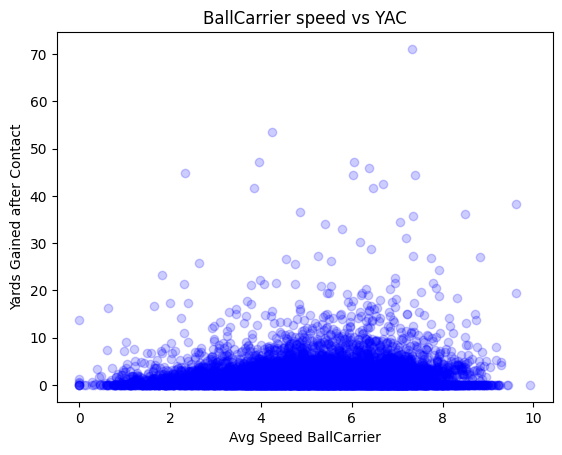

In [122]:
# Create a scatter plot
plt.scatter(yac_df['avg_speed_ballcarrier'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Avg Speed BallCarrier')
plt.ylabel('Yards Gained after Contact')
plt.title('BallCarrier speed vs YAC')

# Show the plot
plt.show()

While the correlation between BallCarrier speed and yards gained after contact remains moderate, a clearer trend emerges, particularly highlighting a higher incidence of significant gains when the ballcarrier is moving at a faster speed. It is crucial to note the presence of outliers, particularly in instances of elevated ballcarrier speeds, contributing to the variability in the relationship.

In [16]:
def get_distance(row, tracking_df):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]

    # Filter for the relevant events
    relevant_events = ['handoff', 'run', 'pass_outcome_caught']
    event_frame = selected_tracking[selected_tracking['event'].isin(relevant_events)]['frameId'].values[0]
    
    x_ballcarrier = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == tracking_df.ballCarrierId)]['x'].values[0]
    y_ballcarrier = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == tracking_df.ballCarrierId)]['y'].values[0]
    x_defender = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == defenderId)]['x'].values[0]
    y_defender = tracking_df[(tracking_df.frameId == event_frame) & (tracking_df.nflId == defenderId)]['y'].values[0]
    
    return np.sqrt((x_defender - x_ballcarrier)**2 + (y_defender - y_ballcarrier)**2)


In [17]:
# Apply the function using iterrows()
yac_df.loc[:, 'distance_when_pass_caught'] = yac_df.apply(get_distance, args=(tracking_fc,), axis=1)


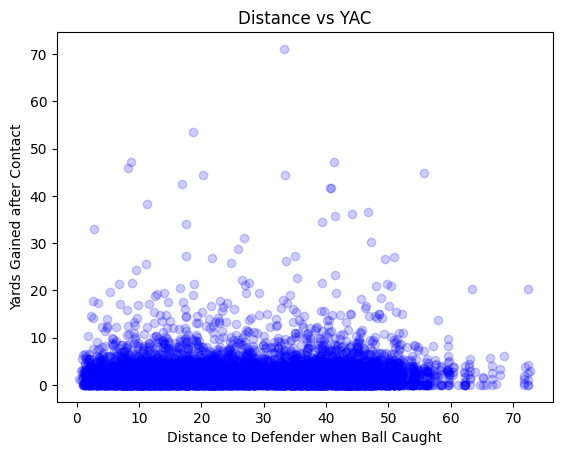

In [128]:
# Create a scatter plot
plt.scatter(yac_df['distance_when_pass_caught'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Distance to Defender when Ball Caught')
plt.ylabel('Yards Gained after Contact')
plt.title('Distance vs YAC')

# Show the plot
plt.show()

While there is no clear linear relationship between the distance between the ballcarrier and the defender at the time the pass was caught and yards gained after contact (YAC), it is possible that underlying patterns in the data, not readily apparent in a linear analysis, may reveal more nuanced associations or dependencies.

In [18]:
def get_num_defenders_near_ball(row, tracking_df):
    gameId = row['gameId']
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']

    selected_play = tracking_df[(tracking_df['gameId'] == gameId) & (tracking_df['playId']==playId)]
    
    # Get the coordinates of the ball carrier
    ball_carrier_row = selected_play[(selected_play['event'] == 'first_contact') & (selected_play['nflId'] == ballCarrierId)]
    x_ballcarrier = ball_carrier_row['x'].values[0]
    y_ballcarrier = ball_carrier_row['y'].values[0]

    # Calculate distances for all defenders
    selected_play['distance_to_ballcarrier'] = np.sqrt((selected_play['x'] - x_ballcarrier)**2 + (selected_play['y'] - y_ballcarrier)**2)

    # Count the number of defenders within 3 yards
    num_defenders_near_ball = len(selected_play[(selected_play['event'] == 'first_contact') & (selected_play['nflId'] != ballCarrierId) & (selected_play['distance_to_ballcarrier'] <= 3)])

    return num_defenders_near_ball

# Apply the function to create the new column
yac_df['num_defenders_near_ball'] = yac_df.apply(lambda row: get_num_defenders_near_ball(row, tracking_fc), axis=1)
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,num_defenders_near_ball
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30,43306.0,5.120000,2.730000,31.056421,1
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52,47843.0,5.296000,6.678000,10.031216,2
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37,4.74,43411.0,3.015625,5.450000,34.698107,4
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35,2.97,47915.0,3.854375,4.212500,35.776463,2
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12,46124.0,5.929048,6.255714,18.725216,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10517,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39,2.26,44829.0,2.845833,5.004167,9.673355,3
10518,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30,1.25,42929.0,3.632500,1.122500,38.431136,1
10519,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41,3.77,38607.0,4.500952,5.387619,44.667342,3
10520,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34,0.00,47971.0,4.518182,3.216364,43.337397,2


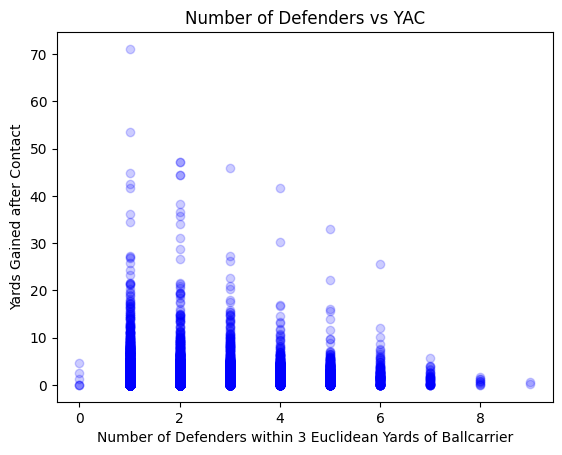

In [133]:
# Create a scatter plot
plt.scatter(yac_df['num_defenders_near_ball'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Number of Defenders within 3 Euclidean Yards of Ballcarrier')
plt.ylabel('Yards Gained after Contact')
plt.title('Number of Defenders vs YAC')

# Show the plot
plt.show()

The proximity of multiple defenders to the ballcarrier at the time of contact is evidently associated with a reduction in yards gained. This observation underscores the significance of retaining this feature in our models, as it serves as a crucial indicator of the defensive pressure exerted on the ballcarrier and its impact on yards gained outcomes.

In [19]:
# Angle difference at first contact
def get_angles(row, tracking_df, event):
    gameId = row['gameId']
    playId = row['playId']
    defenderId = row['defender_first_contact']
    ballCarrierId = row['ballCarrierId']
    
    selected_tracking = tracking_df[(tracking_df.gameId == gameId) & (tracking_df.playId == playId)]
    angle_ballcarrier = selected_tracking[(selected_tracking.nflId == ballCarrierId) & (selected_tracking.event == event)]['o'].values[0]
    angle_defender = selected_tracking[(selected_tracking.nflId == defenderId) & (selected_tracking.event == event)]['o'].values[0]
    
    offense_angle = 0
    if selected_tracking['playDirection'].values[0] == 'left':
        offense_angle = 270
    else:
        offense_angle = 90
    
    raw_angle_difference = angle_defender - angle_ballcarrier
    standardized_angle_difference = (raw_angle_difference - offense_angle) % 360
    
    return standardized_angle_difference

In [20]:
yac_df.loc[:, 'angle_difference'] = yac_df.apply(get_angles, args=(tracking_fc, 'first_contact'), axis=1)

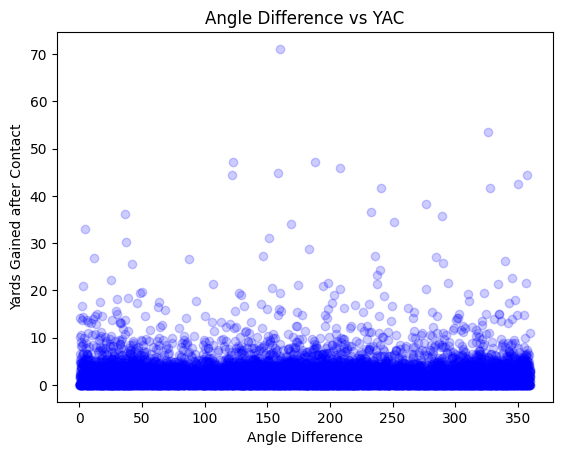

In [134]:
# Create a scatter plot
plt.scatter(yac_df['angle_difference'], yac_df['yards_after_contact'], color='blue', marker='o', alpha=0.2)

# Add labels and title
plt.xlabel('Angle Difference')
plt.ylabel('Yards Gained after Contact')
plt.title('Angle Difference vs YAC')

# Show the plot
plt.show()

Although a distinct linear relationship is not evident, the lack of clarity in the current analysis doesn't preclude the potential usefulness of the feature in more sophisticated models. Robust algorithms like Gradient Boosting and Random Forests can accommodate a broader set of features, and the inclusion of additional variables, even without a clear linear relationship, may enhance the model's capacity to capture intricate patterns in the data without adversely affecting its performance.

## Specify what kind of play it is and convert to a dummy variable

In [21]:

# Create a boolean mask for the specified events and matching player IDs
event_mask = ((tracking_fc['event'] == 'pass_outcome_caught') | 
              (tracking_fc['event'] == 'run') | 
              (tracking_fc['event'] == 'handoff')) & (tracking_fc['nflId'] == tracking_fc['ballCarrierId'])

# Apply the mask to filter rows in tracking_fc
tracking_event = tracking_fc.loc[event_mask]

# Resetting the index if needed
tracking_event.reset_index(drop=True, inplace=True)

#Add what kind of play it is to yac_df
yac_df = pd.merge(yac_df, tracking_event[['gameId', 'playId', 'event']], on=['gameId', 'playId'], how='left')

# Convert to dummy variable
yac_df = pd.get_dummies(yac_df, columns=['event'], prefix='event', dummy_na=True)
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,num_defenders_near_ball,angle_difference,event_handoff,event_pass_outcome_caught,event_run,event_nan
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,41,0.30,43306.0,5.120000,2.730000,31.056421,1,232.09,False,True,False,False
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,30,1.52,47843.0,5.296000,6.678000,10.031216,2,181.57,False,True,False,False
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,37,4.74,43411.0,3.015625,5.450000,34.698107,4,23.17,True,False,False,False
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,35,2.97,47915.0,3.854375,4.212500,35.776463,2,83.34,True,False,False,False
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,18,1.12,46124.0,5.929048,6.255714,18.725216,2,84.48,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8718,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,39,2.26,44829.0,2.845833,5.004167,9.673355,3,203.13,True,False,False,False
8719,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,30,1.25,42929.0,3.632500,1.122500,38.431136,1,80.41,False,True,False,False
8720,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,41,3.77,38607.0,4.500952,5.387619,44.667342,3,316.26,True,False,False,False
8721,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,34,0.00,47971.0,4.518182,3.216364,43.337397,2,299.82,True,False,False,False


## Add player height and weights

In [22]:
players_defense = players[players.position.isin(['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB'])]
players_defense = players_defense.rename(columns={'nflId': 'defender_first_contact'})

players_offense = players[players.position.isin(['QB', 'T', 'TE', 'WR', 'G', 'C', 'RB', 'FB'])]
players_offense = players_offense.rename(columns={'nflId': 'ballCarrierId'})


# Merging Defense Information:
yac_df = pd.merge(yac_df, players_defense[['defender_first_contact', 'height', 'weight']],
                  on='defender_first_contact',
                  how='left')

# Rename Defense Columns:
yac_df = yac_df.rename(columns={'height': 'defender_height', 'weight': 'defender_weight'})

# Merging Offense Information:
yac_df = pd.merge(yac_df, players_offense[['ballCarrierId', 'height', 'weight']],
                  on='ballCarrierId',
                  how='left')

# Rename Offense Columns:
yac_df = yac_df.rename(columns={'height': 'offense_height', 'weight': 'offense_weight'})


In [23]:
#Convert height to inches
def height_to_inches(height_str):
    if height_str is None:
        return None
    
    feet, inches = height_str.split('-')
    total_inches = int(feet) * 12 + int(inches)
    return total_inches

yac_df['defender_height'] = yac_df['defender_height'].apply(height_to_inches)
yac_df['offense_height'] = yac_df['offense_height'].apply(height_to_inches)

In [24]:
yac_df = pd.merge(yac_df, plays[['gameId','playId','quarter','down', 'defendersInTheBox', 'absoluteYardlineNumber']], on= ['gameId','playId'],how='left')
yac_df = yac_df.drop(['yardlineNumber'],axis=1)
yac_df


,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,num_defenders_near_ball,angle_difference,event_handoff,event_pass_outcome_caught,event_run,event_nan,defender_height,defender_weight,offense_height,offense_weight,quarter,down,defendersInTheBox,absoluteYardlineNumber
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,1,232.09,False,True,False,False,73,216,75,261,4,1,7.0,69
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,2,181.57,False,True,False,False,72,206,78,255,2,2,6.0,40
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,4,23.17,True,False,False,False,73,328,70,205,3,2,6.0,47
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,2,83.34,True,False,False,False,69,201,67,203,2,1,7.0,75
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,2,84.48,False,True,False,False,70,180,71,220,3,3,5.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8718,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,3,203.13,True,False,False,False,75,300,72,228,1,1,6.0,49
8719,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,1,80.41,False,True,False,False,74,242,76,267,4,1,7.0,40
8720,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,3,316.26,True,False,False,False,74,248,73,220,4,1,6.0,69
8721,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,2,299.82,True,False,False,False,71,224,71,221,3,1,6.0,44


In [25]:
# Assuming the columns 'defender_height', 'defender_weight', 'offense_height', 'offense_weight' exist in 'yac_df'
# Convert height from inches to meters (1 inch = 0.0254 meters)
yac_df['defender_height_m'] = yac_df['defender_height'] * 0.0254
yac_df['offense_height_m'] = yac_df['offense_height'] * 0.0254

# Convert weight from pounds to kilograms (1 pound = 0.453592 kilograms)
yac_df['defender_weight_kg'] = yac_df['defender_weight'] * 0.453592
yac_df['offense_weight_kg'] = yac_df['offense_weight'] * 0.453592

# Calculate BMI
yac_df['defender_BMI'] = yac_df['defender_weight_kg'] / (yac_df['defender_height_m'] ** 2)
yac_df['offense_BMI'] = yac_df['offense_weight_kg'] / (yac_df['offense_height_m'] ** 2)

# Calculate BMI difference
yac_df['BMI_diff'] = yac_df['offense_BMI'] - yac_df['defender_BMI']

# Calculate speed difference
yac_df['speed_diff'] = yac_df['avg_speed_ballcarrier'] - yac_df['avg_speed_defender']


In [26]:
yac_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,num_defenders_near_ball,angle_difference,event_handoff,event_pass_outcome_caught,event_run,event_nan,defender_height,defender_weight,offense_height,offense_weight,quarter,down,defendersInTheBox,absoluteYardlineNumber,defender_height_m,offense_height_m,defender_weight_kg,offense_weight_kg,defender_BMI,offense_BMI,BMI_diff,speed_diff
0,2022100908,3537,48723,Parker Hesse,10,ATL,TB,ATL,0.30,43306.0,5.120000,2.730000,31.056421,1,232.09,False,True,False,False,73,216,75,261,4,1,7.0,69,1.8542,1.9050,97.975872,118.387512,28.497449,32.622402,4.124953,-2.390000
1,2022091111,1148,42547,Darren Waller,5,LV,LAC,LV,1.52,47843.0,5.296000,6.678000,10.031216,2,181.57,False,True,False,False,72,206,78,255,2,2,6.0,40,1.8288,1.9812,93.439952,115.665960,27.938313,29.467882,1.529569,1.382000
2,2022100212,2007,46461,Mike Boone,10,DEN,LV,DEN,4.74,43411.0,3.015625,5.450000,34.698107,4,23.17,True,False,False,False,73,328,70,205,3,2,6.0,47,1.8542,1.7780,148.778176,92.986360,43.273904,29.414111,-13.859792,2.434375
3,2022091900,1372,47857,Devin Singletary,10,BUF,TEN,TEN,2.97,47915.0,3.854375,4.212500,35.776463,2,83.34,True,False,False,False,69,201,67,203,2,1,7.0,75,1.7526,1.7018,91.171992,92.079176,29.682182,31.793943,2.111760,0.358125
4,2022103001,2165,54616,Tyler Allgeier,17,ATL,CAR,ATL,1.12,46124.0,5.929048,6.255714,18.725216,2,84.48,False,True,False,False,70,180,71,220,3,3,5.0,28,1.7780,1.8034,81.646560,99.790240,25.827025,30.683432,4.856407,0.326667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8718,2022100204,123,43293,Ezekiel Elliott,10,DAL,WAS,WAS,2.26,44829.0,2.845833,5.004167,9.673355,3,203.13,True,False,False,False,75,300,72,228,1,1,6.0,49,1.9050,1.8288,136.077600,103.418976,37.497014,30.922016,-6.574997,2.158333
8719,2022091200,3467,46189,Will Dissly,10,SEA,DEN,SEA,1.25,42929.0,3.632500,1.122500,38.431136,1,80.41,False,True,False,False,74,242,76,267,4,1,7.0,40,1.8796,1.9304,109.769264,121.109064,31.070617,32.499900,1.429283,-2.510000
8720,2022101605,3371,44860,Joe Mixon,10,CIN,NO,CIN,3.77,38607.0,4.500952,5.387619,44.667342,3,316.26,True,False,False,False,74,248,73,220,4,1,6.0,69,1.8796,1.8542,112.490816,99.790240,31.840963,29.025179,-2.815784,0.886667
8721,2022100207,2777,52449,Jonathan Taylor,10,IND,TEN,TEN,0.00,47971.0,4.518182,3.216364,43.337397,2,299.82,True,False,False,False,71,224,71,221,3,1,6.0,44,1.8034,1.8034,101.604608,100.243832,31.241313,30.822902,-0.418410,-1.301818


## Let's add a "broken tackle" column to look at classification models as well as regression

In [27]:
tackles_2 = tackles.copy()
tackles_2 = tackles_2.rename(columns={'nflId': 'defender_first_contact'})

In [106]:
#If the ballcarrier gets 5 or more yards after contact, or is listed as a pff_missedTackle, we'll consider the tackle to be broken
yac_df = pd.merge(yac_df, tackles_2[['gameId', 'playId', 'defender_first_contact', 'pff_missedTackle']],
                       on=['gameId', 'playId', 'defender_first_contact'], how='left')

In [107]:
#Let's consider a gain of 3 yards after contact to be an 'unsuccessful tackle'. After all, in many cases this could be the difference between a first down
yac_df['broken_tackle'] = np.where((yac_df['yards_after_contact'] >= 3), True, False)

In [94]:
yac_df.dropna(subset=['defendersInTheBox'], inplace=True)

## Random Forest Classification

In [141]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest classifier without resampling
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Random Forest model on the original data
model_rf.fit(X_train, y_train)

# Making predictions on the test set using the trained model
y_pred_rf = model_rf.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[1237   40]
 [ 425   43]]
              precision    recall  f1-score   support

       False       0.74      0.97      0.84      1277
        True       0.52      0.09      0.16       468

    accuracy                           0.73      1745
   macro avg       0.63      0.53      0.50      1745
weighted avg       0.68      0.73      0.66      1745



The confusion matrix for the Random Forest classifier reveals that it achieved a high number of True Negatives (1237) but struggled with both True Positives (43) and False Negatives (425), resulting in a precision-recall imbalance. With a significantly lower number of observations for the "True" class, corresponding to plays with a broken tackle, the model exhibits challenges in correctly identifying these instances, leading to a low recall for the positive class. To address this issue, we plan to implement SMOTE (Synthetic Minority Over-sampling Technique) to synthetically generate more examples of the minority class, enhancing the model's ability to capture and generalize patterns related to broken tackles and thereby improve recall for the "True" class.

In [95]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Creating a Random Forest classifier with resampled data
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Random Forest model on the resampled data
model_rf.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_rf = model_rf.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[1112  165]
 [ 352  116]]
              precision    recall  f1-score   support

       False       0.76      0.87      0.81      1277
        True       0.41      0.25      0.31       468

    accuracy                           0.70      1745
   macro avg       0.59      0.56      0.56      1745
weighted avg       0.67      0.70      0.68      1745



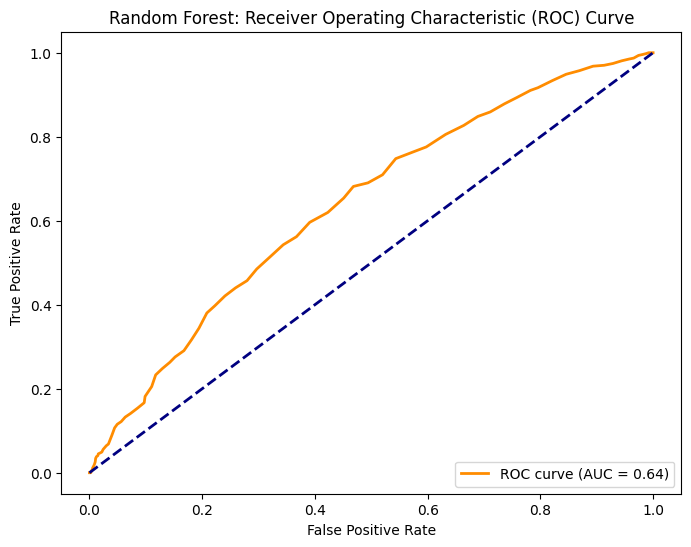

In [139]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The confusion matrix reveals that the Random Forest classifier correctly predicted 1112 instances of non-broken tackles (True Negatives) and 116 instances of broken tackles (True Positives). However, it struggled with false negatives (352 instances) and false positives (165 instances), indicating challenges in accurately identifying broken tackles. The model's overall performance, with an accuracy of 70% and an AUC of 0.64, suggests a moderate ability to discriminate between broken and non-broken tackles, but further refinement may be needed to address imbalances in precision and recall for a more robust classification. Important to note that implementing SMOTE did increase the recall of our minority (True) class.

## XG Boost

In [96]:
# Creating an XGBoost classifier with resampled data
model_xgb = XGBClassifier(n_estimators=100, random_state=42)

# Training the XGBoost model on the resampled data
model_xgb.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_xgb = model_xgb.predict(X_test)

# Print confusion matrix and other metrics for XGBoost model
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[1090  187]
 [ 328  140]]

XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.85      0.81      1277
        True       0.43      0.30      0.35       468

    accuracy                           0.70      1745
   macro avg       0.60      0.58      0.58      1745
weighted avg       0.68      0.70      0.69      1745



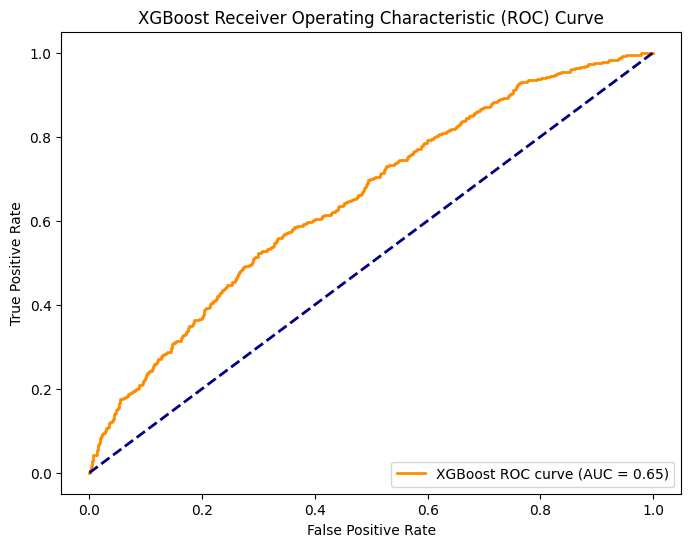


XGBoost AUC: 0.6520540931269201


In [137]:

# Plotting the ROC curve for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, model_xgb.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC curve for XGBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='XGBoost ROC curve (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("\nXGBoost AUC:", roc_auc_xgb)

The confusion matrix for the XGBoost model indicates that it correctly predicted 1090 instances of non-broken tackles (True Negatives) and 140 instances of broken tackles (True Positives). However, it struggled with false negatives (328 instances) and false positives (187 instances), revealing challenges in accurately identifying broken tackles. The model's overall performance, with an accuracy of 70% and an AUC of 0.65, suggests a moderate discriminatory ability, but similar to the Random Forest model, there's room for improvement in balancing precision and recall to enhance the model's robustness in classifying broken tackles.

## Adaptive Boosting

In [144]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# Creating an AdaBoost classifier with resampled and standardized data
model_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training the AdaBoost model on the resampled and standardized data
model_adaboost.fit(X_resampled, y_resampled)

# Making predictions on the test set using the trained model
y_pred_adaboost = model_adaboost.predict(X_test)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))


[[1029  248]
 [ 305  163]]
              precision    recall  f1-score   support

       False       0.77      0.81      0.79      1277
        True       0.40      0.35      0.37       468

    accuracy                           0.68      1745
   macro avg       0.58      0.58      0.58      1745
weighted avg       0.67      0.68      0.68      1745



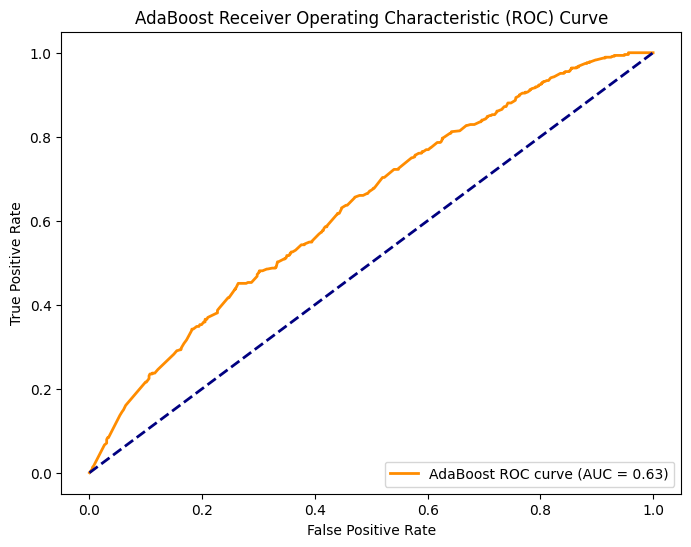


AdaBoost AUC: 0.6333855390237535


In [145]:
# Plotting the ROC curve for AdaBoost
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(y_test, model_adaboost.predict_proba(X_test)[:, 1])
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Plotting the ROC curve for AdaBoost
plt.figure(figsize=(8, 6))
plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=2, label='AdaBoost ROC curve (AUC = {:.2f})'.format(roc_auc_adaboost))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("\nAdaBoost AUC:", roc_auc_adaboost)

The confusion matrix for the AdaBoost model reveals a notable number of True Negatives (1029) and True Positives (163), indicating a relatively balanced performance in predicting both non-broken tackles and broken tackles. However, the model faces challenges with False Negatives (305) and False Positives (248), suggesting limitations in accurately identifying instances of broken tackles. The overall model performance, with an accuracy of 68% and an AUC of 0.63, falls slightly below the performances of the XGBoost and Random Forest models, both of which exhibited higher accuracy and AUC values.

## Dimensionality reduction and then boosting?

In [153]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'speed_diff', 'distance_when_pass_caught',
             'angle_difference', 'BMI_diff', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_resampled_standardized = scaler.fit_transform(X_resampled)

# Apply PCA with 10 components (you can adjust the number of components)
pca = PCA(n_components=5)
X_resampled_pca = pca.fit_transform(X_resampled_standardized)

# Creating an AdaBoost classifier with resampled and PCA-transformed data
model_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training the AdaBoost model on the resampled and PCA-transformed data
model_adaboost.fit(X_resampled_pca, y_resampled)

# Standardize the test data and apply PCA transformation
X_test_standardized = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_standardized)

# Making predictions on the test set using the trained model
y_pred_adaboost = model_adaboost.predict(X_test_pca)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_adaboost))
print(classification_report(y_test, y_pred_adaboost))


[[784 493]
 [259 209]]
              precision    recall  f1-score   support

       False       0.75      0.61      0.68      1277
        True       0.30      0.45      0.36       468

    accuracy                           0.57      1745
   macro avg       0.52      0.53      0.52      1745
weighted avg       0.63      0.57      0.59      1745




The confusion matrix for the AdaBoost model, following dimensionality reduction using Principal Component Analysis (PCA), shows a significant decrease in overall accuracy compared to the previous model. Note that I explored various values for n_components and found 5 to perform the best, though still less accurate than without employing PCA.

## Will a neural network outperform

In [99]:
# Assuming your data is stored in a DataFrame named 'yac_df'
X_columns = ['yardsToGo', 'absoluteYardlineNumber', 'avg_speed_defender', 'avg_speed_ballcarrier', 'distance_when_pass_caught',
             'angle_difference', 'defender_height', 'defender_weight', 'offense_height', 'offense_weight', 'defendersInTheBox',
             'event_handoff', 'event_pass_outcome_caught', 'event_run', 'num_defenders_near_ball']

y_column = 'broken_tackle'

X = yac_df[X_columns]
y = yac_df[y_column]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Build a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Add more layers
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Train the model

model.fit(X_train_standardized, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=2)


# Evaluate the model on the test set
y_pred_nn = (model.predict(X_test_standardized) > 0.5).astype(int)

# Print confusion matrix and other metrics
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


Epoch 1/10
175/175 - 2s - loss: 0.5682 - accuracy: 0.7254 - val_loss: 0.5484 - val_accuracy: 0.7278 - 2s/epoch - 9ms/step
Epoch 2/10
175/175 - 0s - loss: 0.5555 - accuracy: 0.7276 - val_loss: 0.5455 - val_accuracy: 0.7307 - 420ms/epoch - 2ms/step
Epoch 3/10
175/175 - 0s - loss: 0.5492 - accuracy: 0.7299 - val_loss: 0.5454 - val_accuracy: 0.7350 - 393ms/epoch - 2ms/step
Epoch 4/10
175/175 - 0s - loss: 0.5441 - accuracy: 0.7341 - val_loss: 0.5465 - val_accuracy: 0.7335 - 430ms/epoch - 2ms/step
Epoch 5/10
175/175 - 0s - loss: 0.5398 - accuracy: 0.7335 - val_loss: 0.5454 - val_accuracy: 0.7307 - 355ms/epoch - 2ms/step
Epoch 6/10
175/175 - 0s - loss: 0.5326 - accuracy: 0.7391 - val_loss: 0.5489 - val_accuracy: 0.7364 - 397ms/epoch - 2ms/step
Epoch 7/10
175/175 - 0s - loss: 0.5306 - accuracy: 0.7412 - val_loss: 0.5489 - val_accuracy: 0.7256 - 485ms/epoch - 3ms/step
Epoch 8/10
175/175 - 1s - loss: 0.5244 - accuracy: 0.7439 - val_loss: 0.5528 - val_accuracy: 0.7278 - 574ms/epoch - 3ms/step
Epo


The performance metrics for the neural network model reveal a mixed outcome. The model demonstrated a commendable precision of 74% for the negative class, accurately identifying non-broken tackles. However, its recall for the positive class was notably lower at 7%, indicating a substantial challenge in correctly classifying instances of broken tackles. This model is not better

In [101]:
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [102]:
def plot_football_play(playId, gameId, week, plays, games, colors):
    # Filter the DataFrame for the specified playId and gameId
    selected_tracking = week[(week['playId'] == playId) & (week['gameId'] == gameId)]
    selected_play = plays[(plays['playId'] == playId) & (plays['gameId'] == gameId)]
    
    down = selected_play['down'].values[0]
    down_mapping = {
    1: "1st",
    2: "2nd",
    3: "3rd",
    4: "4th"
    }
    down_text = down_mapping.get(down, "Unknown")

    quarter = selected_play['quarter'].values[0]
    quarter_text = down_mapping.get(quarter, "Unknown")
    game_clock = selected_play['gameClock'].values[0]
    playDescription = selected_play['playDescription'].values[0]
    playDirection = selected_tracking['playDirection'].values[0]
    homeTeam = games.homeTeamAbbr.values[0]
    visitorTeam = games.visitorTeamAbbr.values[0]
    ballCarrierId = plays.ballCarrierId.values[0]

    #make the away team white
    modified_colors = colors.copy()
    modified_colors[visitorTeam] = "#FFFFFF"
    
    #Set line of scrimmage and first down
    #Offense on own half and going right
    if (selected_play['possessionTeam'].values[0] == selected_play['yardlineSide'].values[0] and playDirection == 'right'):
        line_of_scrimmage = selected_play['yardlineNumber'].values[0] + 10
        first_down_line = line_of_scrimmage + selected_play['yardsToGo'].values[0]
    #Offense on opponents half and going right
    elif (selected_play['possessionTeam'].values[0] != selected_play['yardlineSide'].values[0] and playDirection == 'right'):
        line_of_scrimmage = 110 - selected_play['yardlineNumber'].values[0]
        first_down_line = line_of_scrimmage + selected_play['yardsToGo'].values[0]
    #Offense on own half and going left
    elif (selected_play['possessionTeam'].values[0] == selected_play['yardlineSide'].values[0] and playDirection == 'left'):
        line_of_scrimmage = 110 - selected_play['yardlineNumber'].values[0]
        first_down_line = line_of_scrimmage - selected_play['yardsToGo'].values[0]
    #Offense on opponents half and going left
    elif (selected_play['possessionTeam'].values[0] != selected_play['yardlineSide'].values[0] and playDirection == 'left'):
        line_of_scrimmage = selected_play['yardlineNumber'].values[0] + 10
        first_down_line = line_of_scrimmage - selected_play['yardsToGo'].values[0]

    scorebug = f'{homeTeam} : {selected_play.preSnapHomeScore.values[0]} {visitorTeam} : {selected_play.preSnapVisitorScore.values[0]} || {quarter_text} {game_clock} || {down_text} and {selected_play.yardsToGo.values[0]}'

    # Create an animated scatter plot with Plotly Express
    scatter_fig = px.scatter(selected_tracking, x='x', y='y', animation_frame='frameId', color='club', color_discrete_map = modified_colors,
                     hover_data=['jerseyNumber', 'displayName', 's', 'event'],
                     title=playDescription)


    # Add football field shapes and annotations
    field_shapes = [
        dict(type='rect', x0=0, x1=10,y0=0,y1=53.3, fillcolor='blue', opacity=0.5),
        dict(type='rect', x0=110, x1=120,y0=0,y1=53.3, fillcolor='blue', opacity=0.5),
        dict(type='line', x0=line_of_scrimmage, x1=line_of_scrimmage,y0=0,y1=53.3, line=dict(color='blue')),
        dict(type='line', x0=first_down_line, x1=first_down_line,y0=0,y1=53.3, line=dict(color='yellow'))
    ]
    for x in range(10, 115, 5):
        field_shapes.append(dict(type='line', x0=x, x1=x, y0=0, y1=53.3, line=dict(color='white', width=1)))


    field_annotations = [
        dict(x=5, y=26.65,textangle=270, text=homeTeam, showarrow=False, font=dict(color='white', size=12)),
        dict(x=115, y=26.65,textangle=90, text=homeTeam, showarrow=False, font=dict(color='white', size=12)),
    ]

    for x in range(20, 70, 10):
        field_annotations.append(dict(x=x, y=8, text=(x-10), showarrow=False, font=dict(color='white', size=12)))
        field_annotations.append(dict(x=x, y=45.3, text=(x-10), showarrow=False, font=dict(color='white', size=12)))
    for x in range(70, 110, 10):
        field_annotations.append(dict(x=x, y=8, text=(110-x), showarrow=False, font=dict(color='white', size=12)))
        field_annotations.append(dict(x=x, y=45.3, text=(110-x), showarrow=False, font=dict(color='white', size=12)))

    title_annotation = dict(
    x=0.5,  # X-coordinate (0.5 is the center of the plot)
    y=-0.2,  # Y-coordinate (negative to position under the plot)
    xref='paper',
    yref='paper',
    text=scorebug,
    showarrow=False,
    font=dict(size=14, color='black')  # Customize the font size and color
    )
    
    # Create football field layout
    field_layout = go.Layout(
        shapes=field_shapes,
        annotations=field_annotations + [title_annotation],
        xaxis=dict(range=[0, 120], title =''),
        yaxis=dict(range=[0, 53.3], title=''),
        showlegend=True,
        height = 533,
        width = 1200
    )
    field_layout['xaxis'].update(showgrid=False)
    field_layout['yaxis'].update(showgrid=False)

    scatter_fig.update_layout(field_layout, plot_bgcolor='green')



    
    # Show the combined plot
    scatter_fig.show()

In [103]:
yac_df[yac_df.gameId == 2022110610]

,gameId,playId,ballCarrierId,ballCarrierDisplayName,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yards_after_contact,defender_first_contact,avg_speed_defender,avg_speed_ballcarrier,distance_when_pass_caught,num_defenders_near_ball,angle_difference,event_handoff,event_pass_outcome_caught,event_run,event_nan,defender_height,defender_weight,offense_height,offense_weight,quarter,down,defendersInTheBox,absoluteYardlineNumber,defender_height_m,offense_height_m,defender_weight_kg,offense_weight_kg,defender_BMI,offense_BMI,BMI_diff,speed_diff,pff_missedTackle,broken_tackle
54,2022110610,2629,41325,Jerick McKinnon,10,KC,TEN,TEN,1.57,46846.0,4.972353,5.253529,29.166119,2,308.77,False,True,False,False,72,203,69,205,3,1,6.0,41,1.8288,1.7526,92.079176,92.986360,27.531444,30.272873,2.741428,0.281176,1,False
141,2022110610,348,54716,Isiah Pacheco,10,KC,TEN,TEN,2.11,44869.0,2.288462,5.348462,45.021366,1,12.34,False,True,False,False,75,238,71,215,1,2,6.0,33,1.9050,1.8034,107.954896,97.522280,29.747631,29.986081,0.238451,3.060000,0,False
472,2022110610,2959,43334,Derrick Henry,10,TEN,KC,TEN,2.16,54568.0,4.040769,6.526154,36.770065,5,295.96,True,False,False,False,74,261,75,247,3,1,7.0,20,1.8796,1.9050,118.387512,112.037224,33.510046,30.872541,-2.637505,2.485385,0,False
550,2022110610,3912,52440,Clyde Edwards-Helaire,1,KC,TEN,KC,1.64,46846.0,2.353333,3.331111,27.872499,6,236.17,True,False,False,False,72,203,68,209,4,4,7.0,55,1.8288,1.7272,92.079176,94.800728,27.531444,31.777989,4.246545,0.977778,0,False
601,2022110610,3593,41325,Jerick McKinnon,10,KC,TEN,TEN,1.24,54500.0,4.230000,3.405000,50.066374,1,102.94,False,True,False,False,72,188,69,205,4,2,6.0,95,1.8288,1.7526,85.275296,92.986360,25.497101,30.272873,4.775771,-0.825000,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8412,2022110610,1719,46506,Dontrell Hilliard,14,TEN,KC,TEN,2.72,35493.0,2.689615,5.635385,17.814963,3,158.16,True,False,False,False,78,285,71,202,2,2,6.0,75,1.9812,1.8034,129.273720,91.625584,32.934692,28.172969,-4.761723,2.945769,0,False
8507,2022110610,2792,54596,Hassan Haskins,14,TEN,KC,TEN,4.12,54600.0,2.820000,4.710000,21.328209,1,165.79,False,True,False,False,75,197,73,220,3,3,5.0,43,1.9050,1.8542,89.357624,99.790240,24.623039,29.025179,4.402140,1.890000,1,True
8543,2022110610,4450,44874,JuJu Smith-Schuster,1,KC,TEN,TEN,2.12,46846.0,7.497500,6.655000,29.166119,1,56.68,False,True,False,False,72,203,73,215,5,4,6.0,23,1.8288,1.8542,92.079176,97.522280,27.531444,28.365516,0.834072,-0.842500,0,False
8590,2022110610,2289,40011,Travis Kelce,10,KC,TEN,KC,4.42,43353.0,2.640000,4.793333,38.421422,2,252.93,False,True,False,False,71,212,77,260,3,2,6.0,85,1.8034,1.9558,96.161504,117.933920,29.567671,30.831159,1.263488,2.153333,0,True


## Lets Examine some of the plays in each category of the confusion matrix

In [173]:
def plot_samples_for_category(true_label, predicted_label, category_name, week, plays, games, colors, num_samples=5):
    indices = (y_test == true_label) & (y_pred_xgb.flatten() == predicted_label)
    sample_indices = X_test.index[indices][:num_samples]
    
    print(f"\n{category_name} Examples:")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

    for i, sample_index in enumerate(sample_indices):
        sample = yac_df.loc[sample_index]
        playId = sample['playId']
        gameId = sample['gameId']
        
        print(f"\nExample {i + 1}:")
        print(f"gameId: {gameId}, playId: {playId}")

        # Print desired columns from yac_df
        columns_to_print = ['yards_after_contact', 'avg_speed_defender',
                             'avg_speed_ballcarrier', 'distance_when_pass_caught', 'num_defenders_near_ball',
                             'angle_difference']
        
        print("Sample Data:")
        for column in columns_to_print:
            print(f"{column}: {sample[column]}")

        # Plot football play
        plot_football_play(playId, gameId, week, plays, games, colors)



False Negatives (FN) Examples:
True Label: 1, Predicted Label: 0

Example 1:
gameId: 2022091105, playId: 4488
Sample Data:
yards_after_contact: 4.340000000000003
avg_speed_defender: 7.026
avg_speed_ballcarrier: 7.034000000000001
distance_when_pass_caught: 1.3182184947875595
num_defenders_near_ball: 1
angle_difference: 260.48


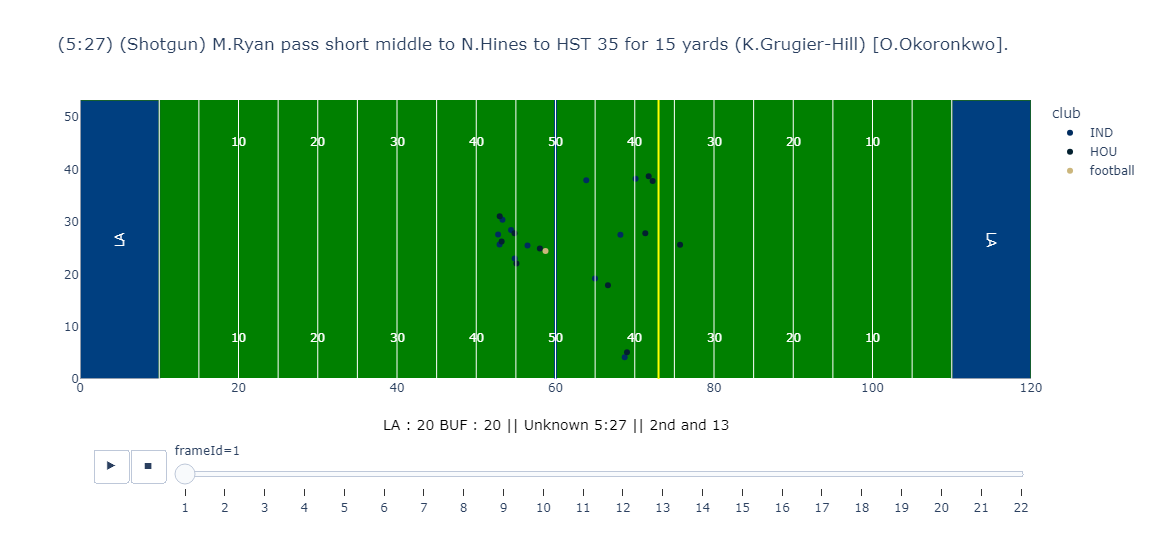


Example 2:
gameId: 2022101611, playId: 1529
Sample Data:
yards_after_contact: 6.179999999999996
avg_speed_defender: 3.4410000000000007
avg_speed_ballcarrier: 4.820000000000001
distance_when_pass_caught: 40.911565601917516
num_defenders_near_ball: 2
angle_difference: 247.26


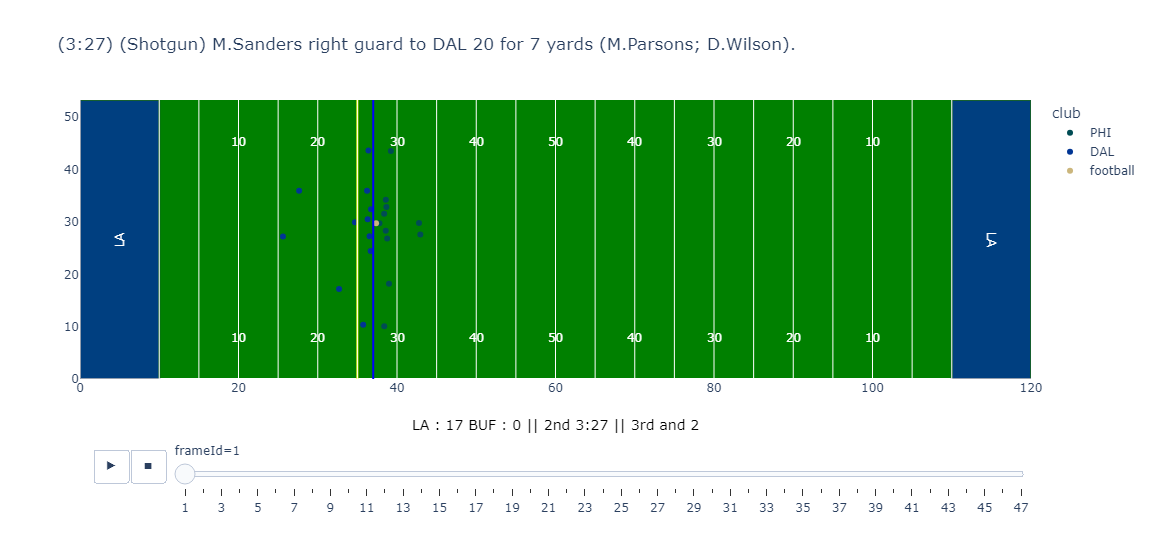


Example 3:
gameId: 2022092506, playId: 3997
Sample Data:
yards_after_contact: 5.420000000000002
avg_speed_defender: 5.54375
avg_speed_ballcarrier: 3.4806250000000003
distance_when_pass_caught: 34.58785914161211
num_defenders_near_ball: 3
angle_difference: 228.52


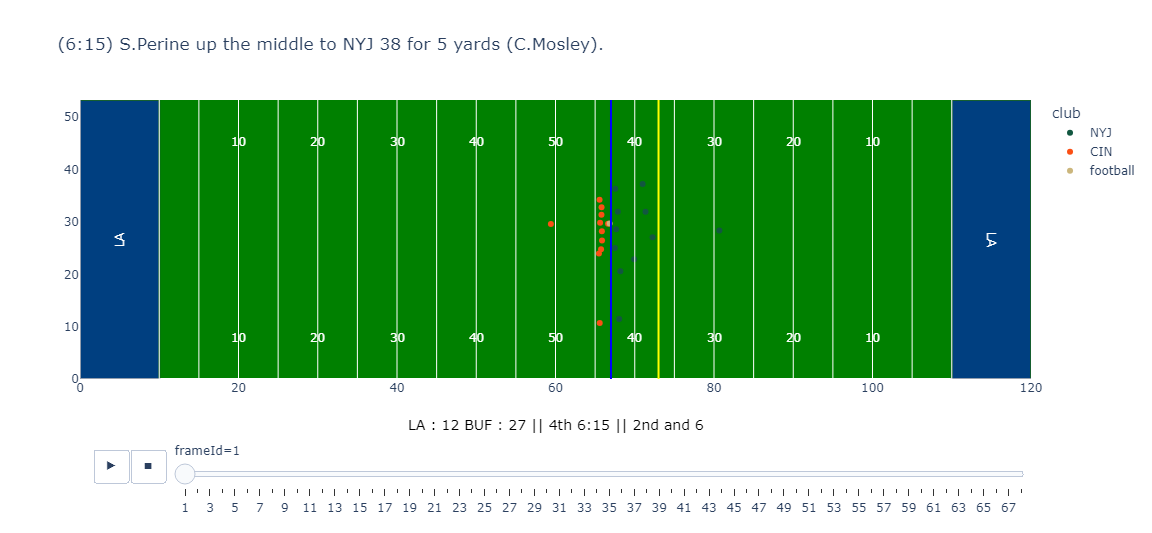


Example 4:
gameId: 2022110300, playId: 695
Sample Data:
yards_after_contact: 4.839999999999998
avg_speed_defender: 5.998666666666666
avg_speed_ballcarrier: 5.6386666666666665
distance_when_pass_caught: 8.47079689285488
num_defenders_near_ball: 3
angle_difference: 170.69000000000005


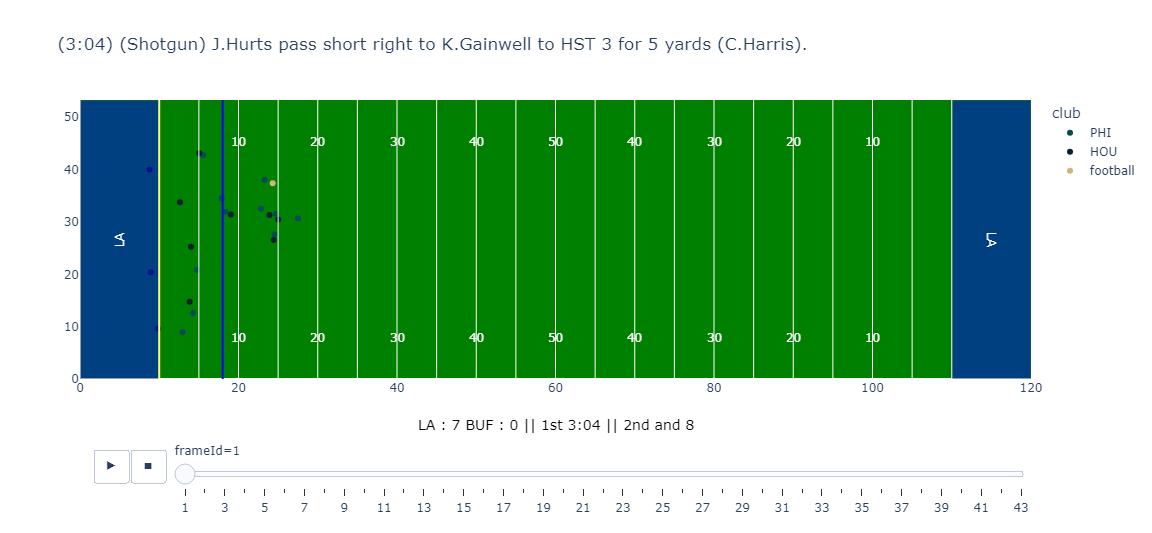


Example 5:
gameId: 2022092501, playId: 724
Sample Data:
yards_after_contact: 5.620000000000001
avg_speed_defender: 4.723076923076923
avg_speed_ballcarrier: 4.2992307692307685
distance_when_pass_caught: 21.982629506044088
num_defenders_near_ball: 4
angle_difference: 160.94


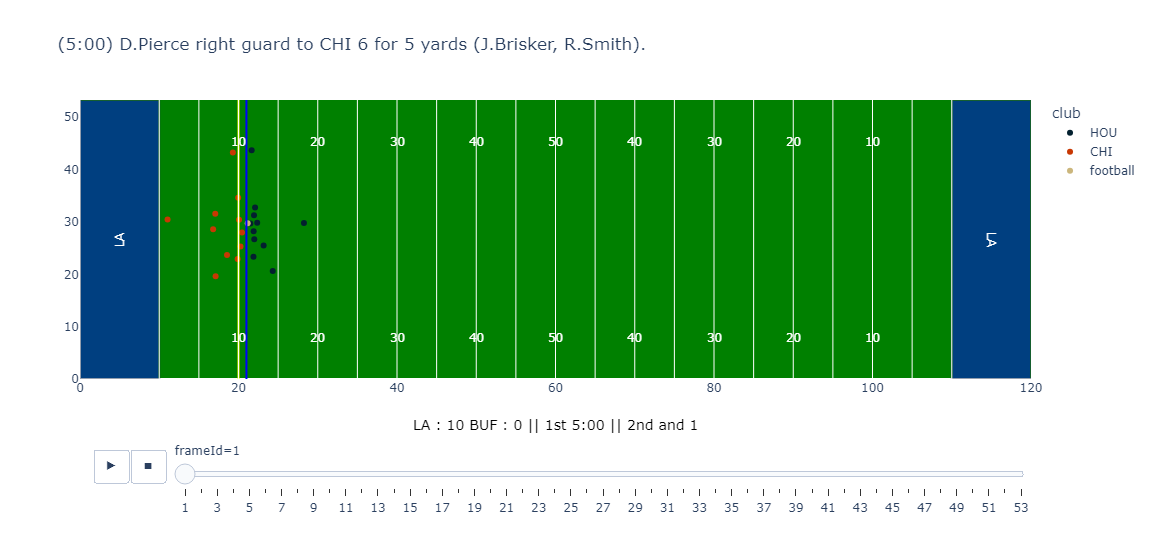

In [174]:
# Most importantly are our False Negatives, or when the model incorrectly predicted that a tackle was successful
plot_samples_for_category(1, 0, 'False Negatives (FN)', tracking, plays, games, colors, num_samples=5)

## Discussion on Potential Sources of Model Limitations in Predicting True Labels

Predicting broken tackles in football plays is indeed a challenging task, and various factors contribute to the model's inability to accurately predict true labels. Let's analyze some specific plays to identify potential reasons for misclassifications:

### Play 1: M.Ryan pass short middle to N.Hines
Despite Hines' quick movement (7.03), the model incorrectly predicted the outcome. One possible reason could be the absence of contextual information regarding defensive strategies or player agility. The model might not fully capture the nuanced interactions between offensive and defensive players during a pass play.

### Play 2: M.Sanders right guard (run)
The model's misclassification of this play, where Sanders is not moving particularly fast (4.8) and faces two defenders, raises questions about the feature set's effectiveness. It may lack certain features capturing player agility or the defensive line's strength, which are crucial in assessing the success of running plays.

### Play 3: S. Perine up the middle
In the case of Perine's run up the middle, the model struggled to predict the outcome. The choice of running direction and the number of defenders near the ballcarrier could be critical factors. Incorporating information about offensive line capabilities and defensive strategies specific to running up the middle may enhance the model's predictive power.

### Play 4: J.Hurts pass short right to K.Gainwell
Gainwell's play, characterized by moderate speed and three defenders nearby, presents a scenario where the model likely grapples with the complexity of pass plays. Understanding the spatial dynamics and defensive coverage strategies during passing plays could be crucial for better predictions.

### Play 5: D.Pierce
Similar to the Perine play, the model's struggle with Pierce's run could be attributed to the inherent difficulty of running plays with multiple defenders nearby. Factors such as offensive line effectiveness and defensive tactics need more nuanced consideration for accurate predictions.

### Key Takeaways:
1. **Contextual Information:**
   - Incorporating contextual information related to defensive strategies, player agility, and offensive line strength could improve the model's understanding of intricate play dynamics.

2. **Spatial Awareness:**
   - Spatial dynamics, especially during passing plays, require careful consideration. Awareness of defensive coverage and offensive strategies is crucial for accurate predictions.

3. **Position-Specific Features:**
   - Tailoring the feature set to include position-specific characteristics, such as running back or quarterback attributes, may enhance the model's ability to distinguish between successful and unsuccessful plays.

4. **Minority Class:**
   - Ultimately, the model grapples with a data deficiency in the minority class, specifically the (True) label denoting broken tackles. While the model sees enhancement through the synthetic creation of data, it falls short of the potency achieved with a more substantial representation of plays where tackles were broken.mplex landscape of football plays.
